# Statistics on Logistic Regression

We will arange data and train LogisticRegression classifier on the data.
The we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic Classifier

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [2]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.INFO)
stocks = [TrainingData(sn).add_history(10).set_threshold(0.8).get() for sn in stock_names]

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018134653877025918
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.026397640541565882
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.018548151336335694
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0.036464497748678756
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.0321798749747933


In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [4]:
def run_model(model, stocks=stocks):
    scores = {sn: [] for sn in stock_names}
    validation_rounds = 3
    for i in range(validation_rounds):
        for sn, (data, classes) in zip(stock_names, stocks):
            scores[sn].append(sum(cross_val_score(model, data, classes))/3) 
    for sn in scores.keys():
        scores[sn] = sum(scores[sn])/validation_rounds
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

## Logistic Regression

This one is pretty powerful and again with data scaled should work excelently. This is expected to bring the best results.

We will look at penalty function (norm), regularization strength (C param), intercept_scaling (the constant added to class calc, should play with this a little), max_iter and tol (tolerance for stopping).

In [5]:
from sklearn.linear_model import LogisticRegression

# create iterables for all options and use itertools product
penaltys = ['l1', 'l2']
Cs = [0.5, 0.7, 1.0, 1.3, 1.5]
intercept_scalings = [0.5, 0.7, 1.0, 1.3, 1.5]
max_iters = [3, 10, 20, 100]
tols = [0.00007, 0.0001, 0.0005]

lmodels = [LogisticRegression(C=c, penalty=p, intercept_scaling=isc, max_iter=mi, tol=t) 
          for c, p, isc, mi, t in product(Cs, penaltys, intercept_scalings, max_iters, tols)]

In [6]:
laccuracies = list(map(run_model, lmodels))

In [7]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(lmodels, laccuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.penalty, model.intercept_scaling, model.max_iter, model.tol, sn, acc))

lresults = DataFrame(data, columns=('C', 'penalty', 'intercept_scaling', 'max_iter', 'tol', 'stock', 'accuracy'))

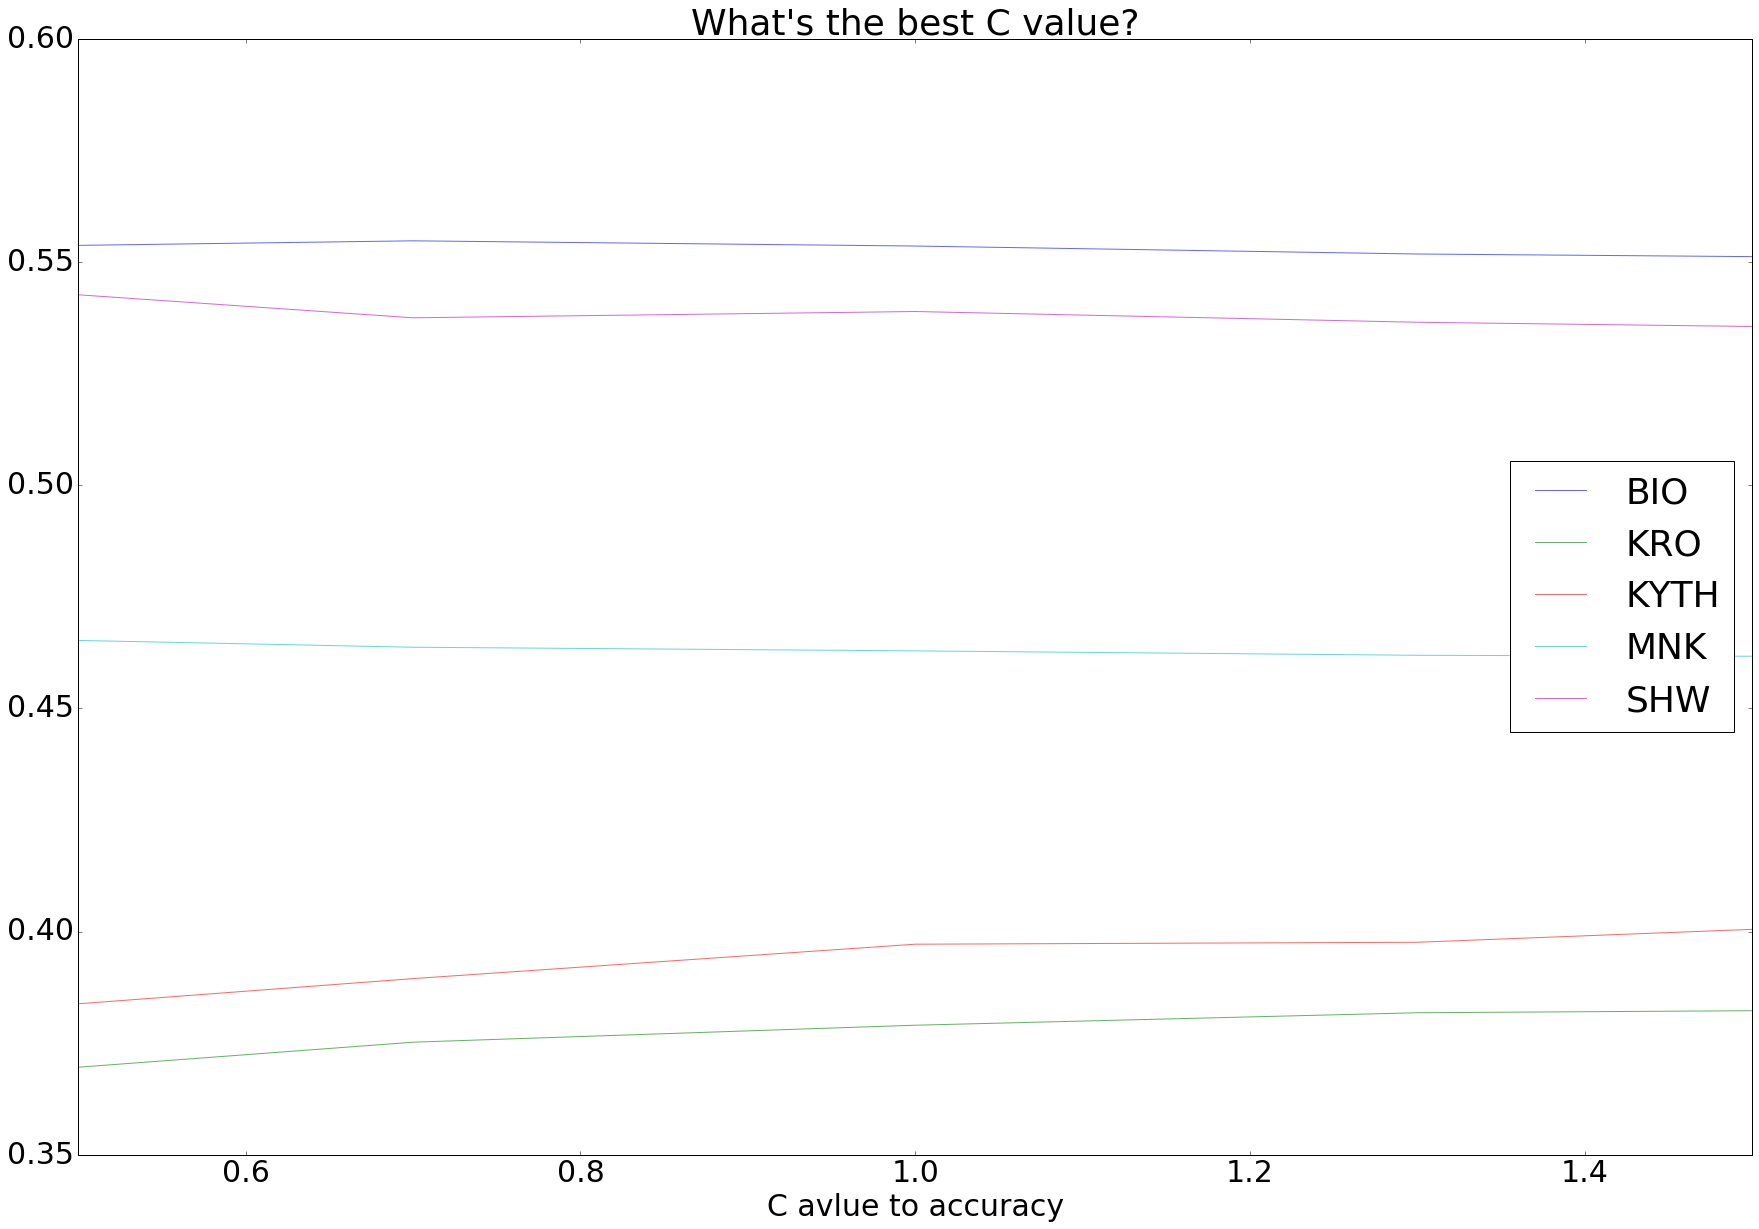

In [8]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

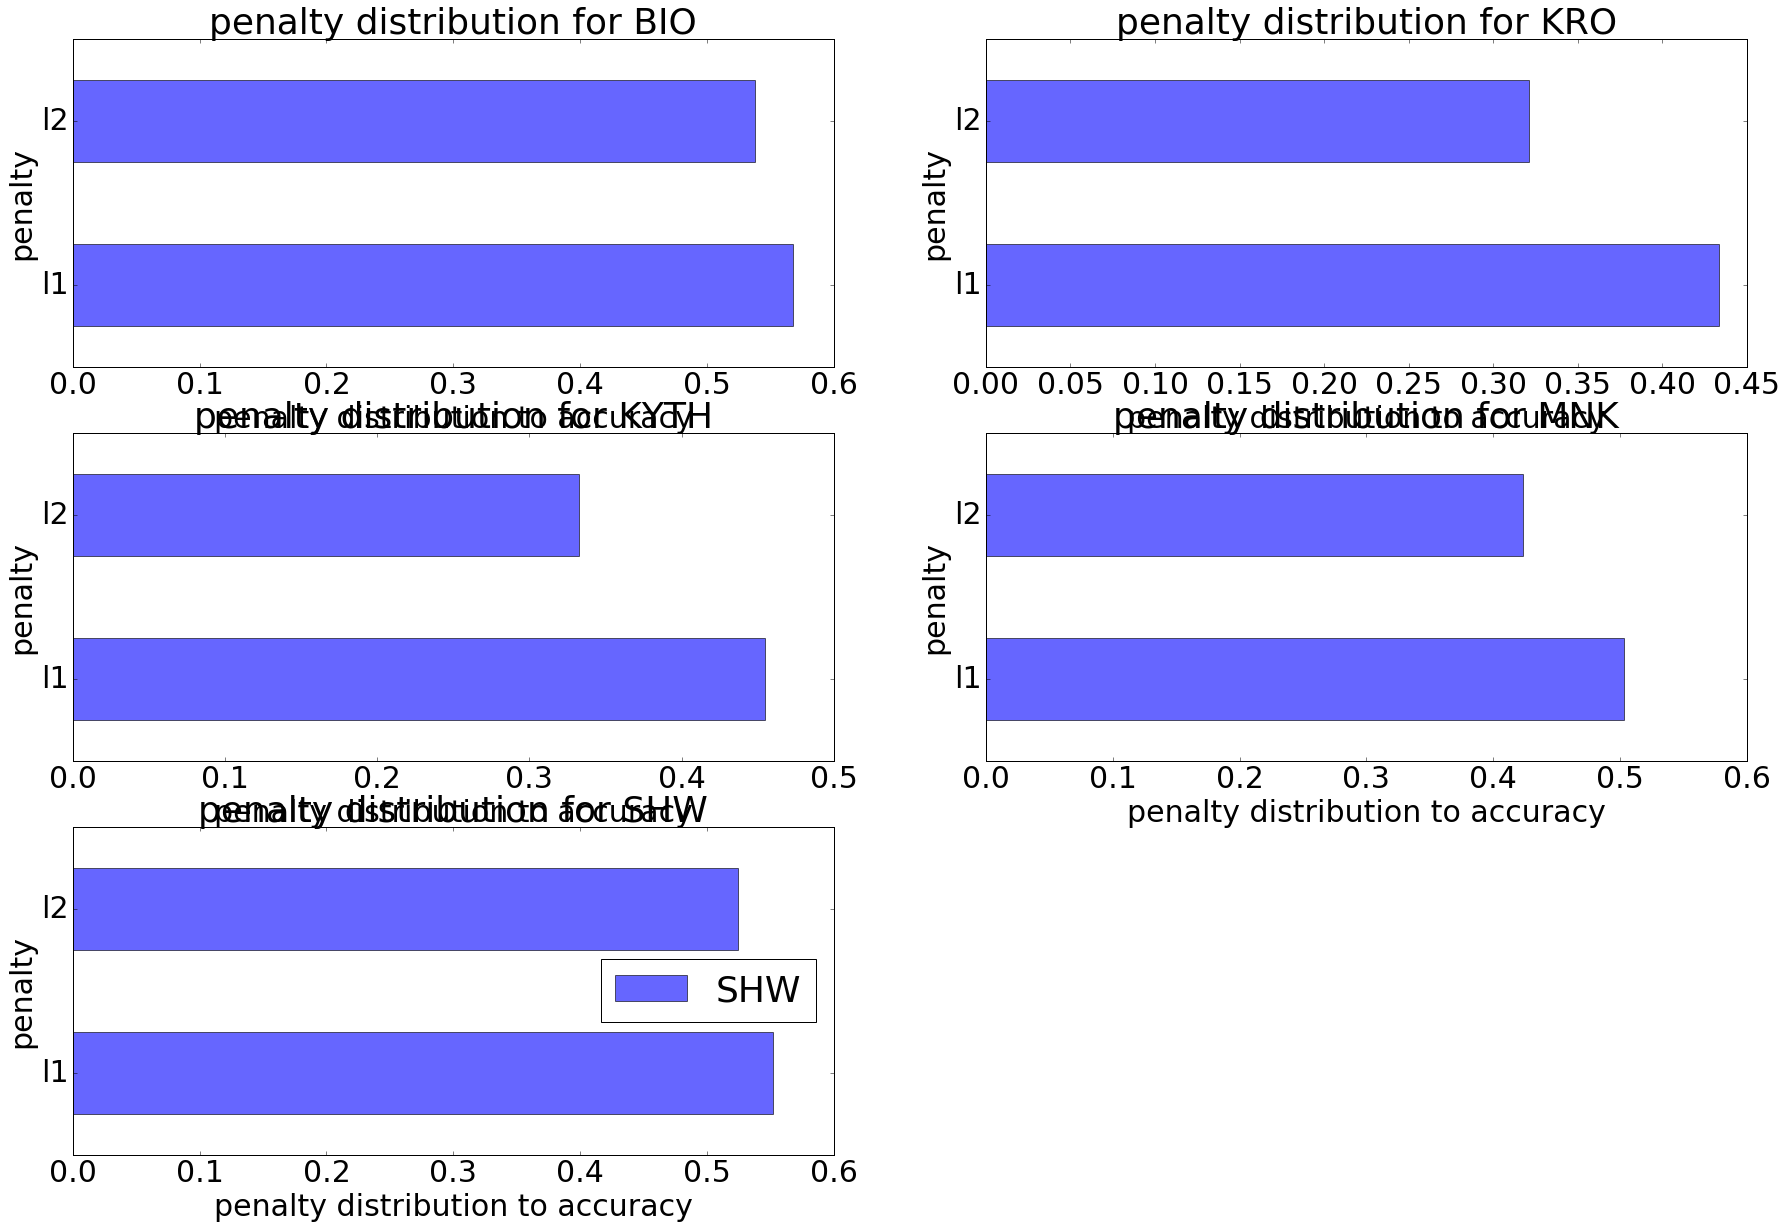

In [9]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(lresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.groupby('penalty').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('penalty distribution to accuracy')
    ax1.set_title("penalty distribution for {}".format(name))
plt.legend(loc='best')


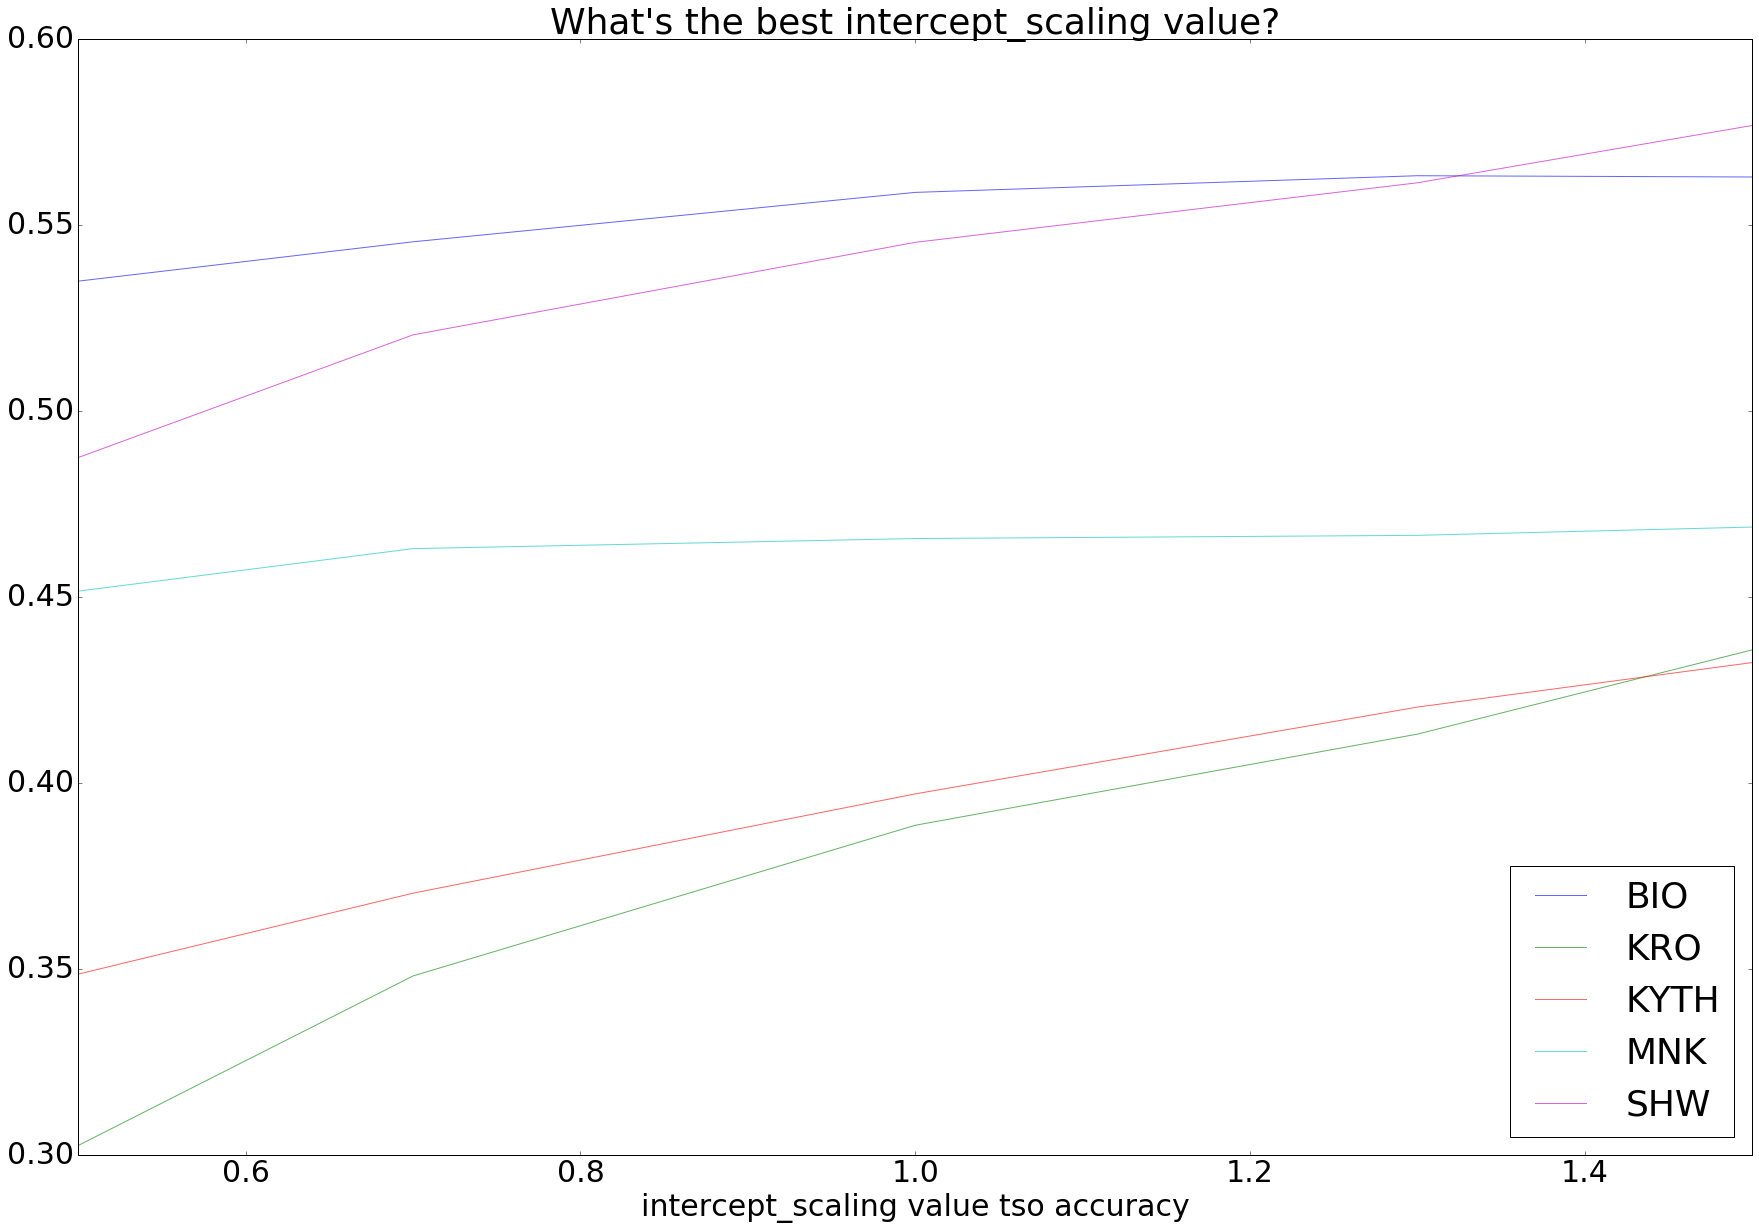

In [10]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('intercept_scaling').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('intercept_scaling value tso accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best intercept_scaling value?" )

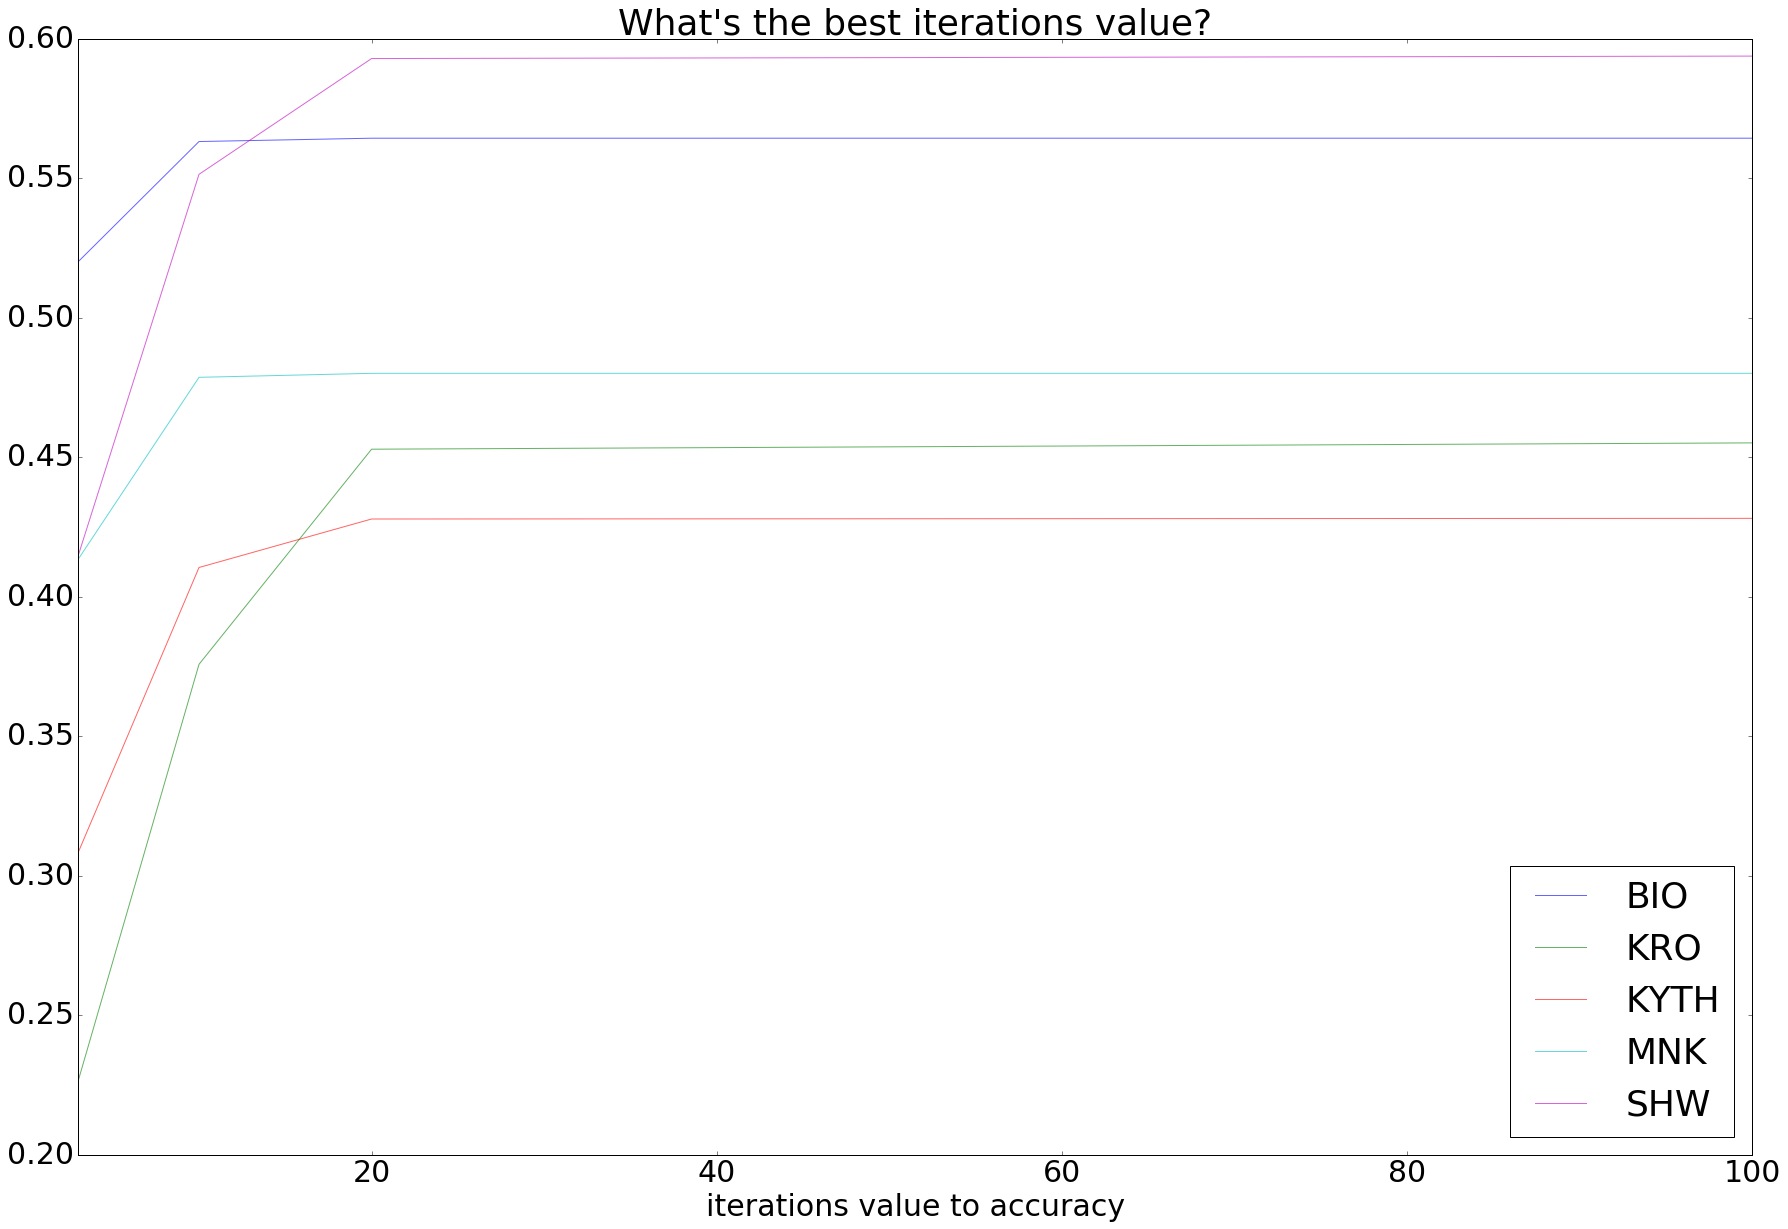

In [11]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('iterations value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best iterations value?" )

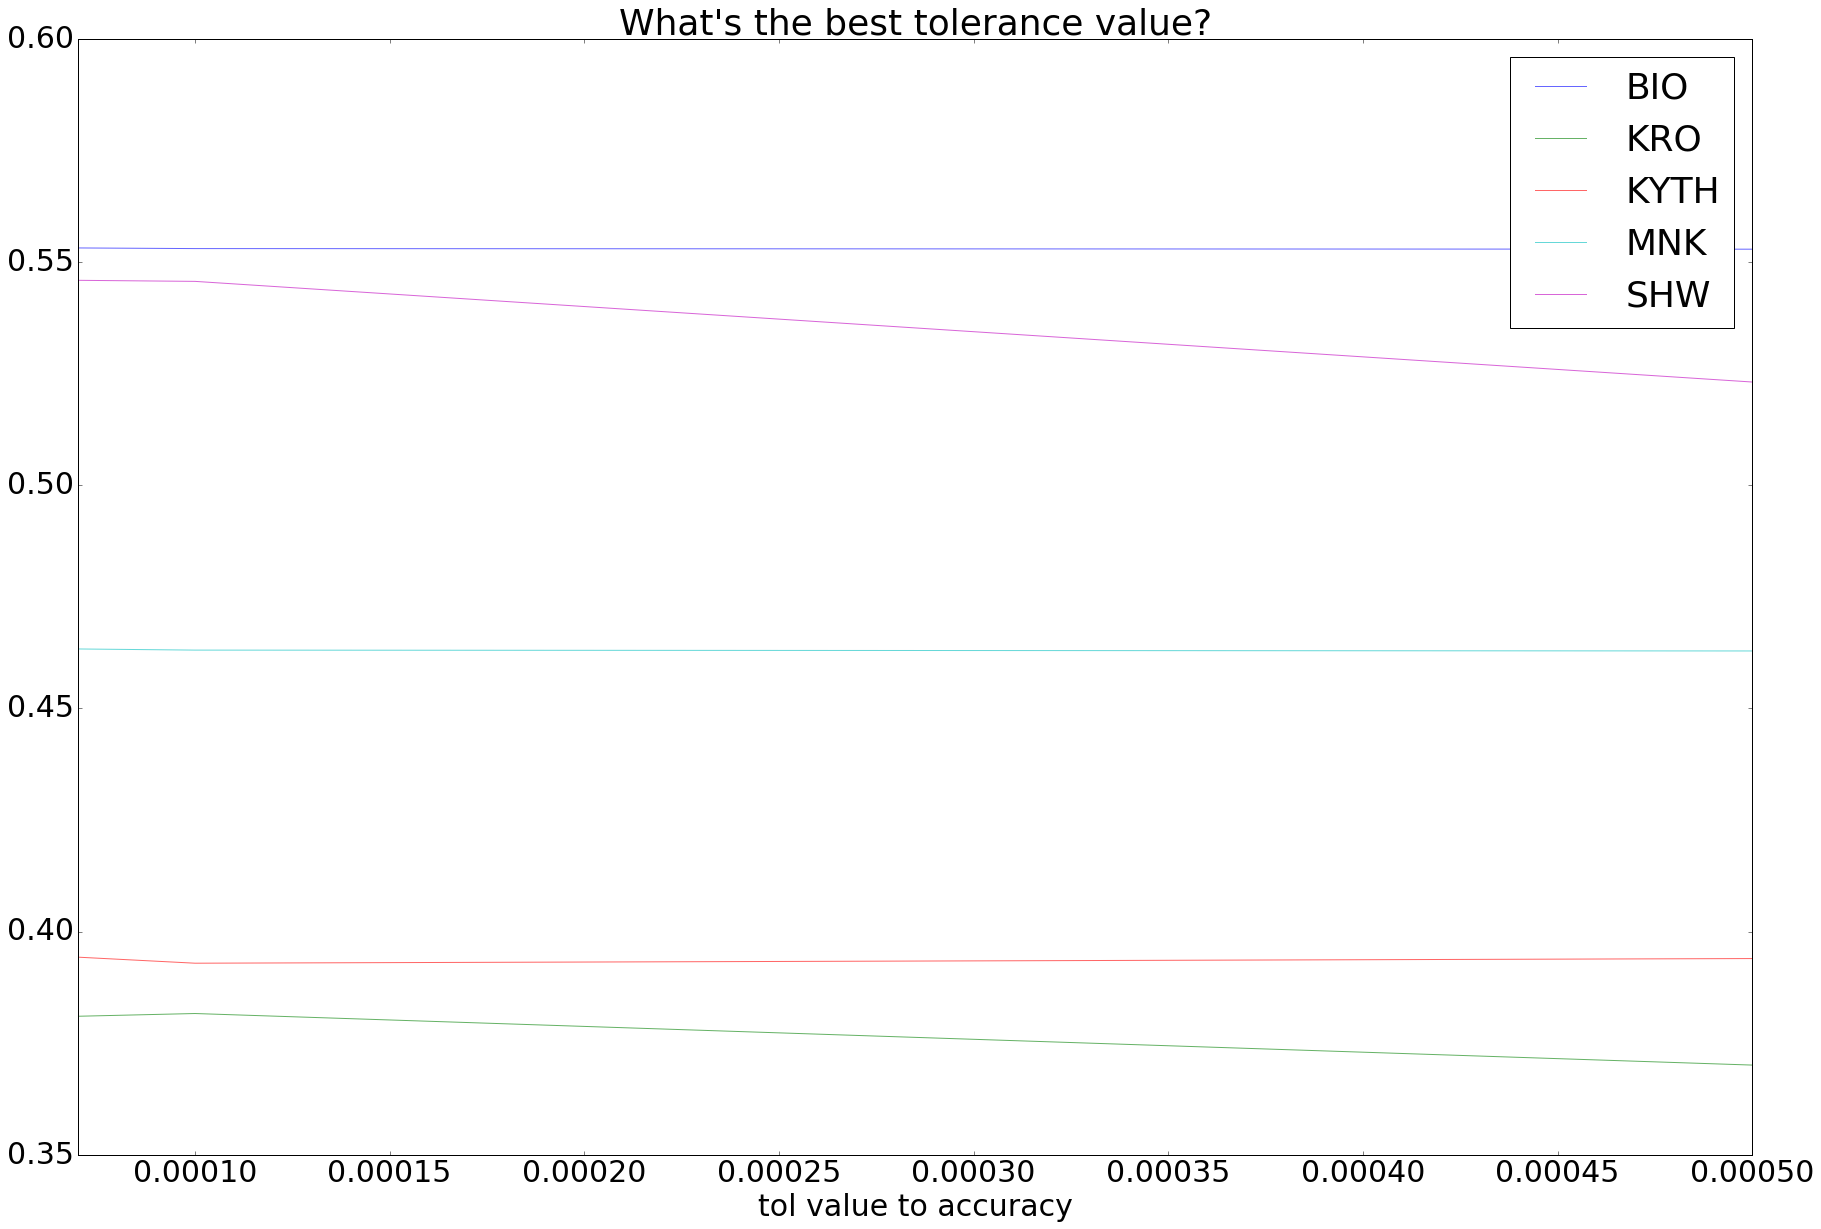

In [12]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('tol').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('tol value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best tolerance value?" )

In [13]:
print(get_best_model(lmodels, laccuracies))
print(get_best_median_model(lmodels, laccuracies))

(2.9246271899324894, LogisticRegression(C=0.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.5, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=7e-05,
          verbose=0, warm_start=False))
(0.58438715585612311, LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.3, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=7e-05,
          verbose=0, warm_start=False))


Well this sucks.

# Using the Quarter Classifier

In [15]:
import Classifiers
from Classifiers.classifiers import Quarter

q_clusterer = Classifiers.create_quarter_clusterer(ld)

In [16]:
import functools

quarters = [list(map(lambda q: q.ready_quarter_data(360), Quarter.split_by_quarters(sn, data))) for sn, (data, classes) in zip(stock_names, stocks)]
drop_cols = list(ld.get_stock_data(stock_names[0]).columns)
drop_cols.remove('open')
drop_cols.remove('volume')
quarters = list(functools.reduce(lambda x, y: x+y, quarters))

In [18]:
def arrange_data_frame(data: pandas.DataFrame, length: int):
    res = None
    data = data.iloc[0:length]

    for i, c in enumerate(data.columns):
        cur = data[c]
        cur.index = list(range(i*length, (i+1)*length))
        if res is None:
            res = cur
            continue
        res = res.append(cur)
    return res

In [23]:
import collections

c_to_qs = collections.defaultdict(lambda: [])
for q, c in zip(quarters, q_clusterer.predict(list(map(lambda q: arrange_data_frame(q.data, 353), quarters)))):
    c_to_qs[c].append(q)

for c, qs in c_to_qs.items():
    all_dc = [Utilities.orginizers.TrainingData(q.name.split('-')[0], ld=ld, startdate=q.start, enddate=q.end, threshold=0.8).add_history(10) for q in qs]
    data = []
    classes = []
    for sn in stock_names:
        temp_d = []
        temp_c = []
        for td in filter(lambda td: td.name == sn, all_dc):
            d, c = td.get()
            temp_d.append(d)
            temp_c.append(c)
        try:
            data.append(functools.reduce(lambda a, b: pandas.concat([a, b]), temp_d))
            classes.append(functools.reduce(lambda a, b: pandas.concat([a, b]), temp_c))
        except:
            continue
    data = [TrainingData.cleanup_data(d) for d in data]

    model1 = get_best_model(lmodels, laccuracies)[1]
    accs = run_model(model1, list(zip(data, classes)))
    print("{}: {}".format(c, accs))



INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.0238815467021425
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.010627930741388071
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013781512605042005
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.011651678914481971
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01511784175165661
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013291602851652297
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014380000186028159
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.012995382801272702
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.008780129278374625
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014561780175750775
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.010470521895491898
INFO:root:Tra

date
2016-07-01    False
2016-07-05     True
2016-07-06     True
2016-07-07    False
2016-07-08    False
2016-07-11    False
2016-07-12    False
2016-07-13    False
2016-07-14    False
2016-07-15    False
2016-07-18    False
2016-07-19    False
2016-07-20    False
2016-07-21    False
2016-07-22    False
2016-07-25    False
2016-07-26     True
2016-07-27    False
2016-07-28    False
2016-07-29    False
2016-08-01     True
2016-08-02     True
2016-08-03    False
2016-08-04     True
2016-08-05    False
2016-08-08     True
2016-08-09    False
2016-08-10    False
2016-08-11    False
2016-08-12    False
2016-08-15    False
2016-08-16    False
2016-08-17    False
2016-08-18    False
2016-08-19    False
2016-08-22    False
2016-08-23    False
2016-08-24     True
2016-08-25    False
2016-08-26    False
2016-08-29    False
2016-08-30    False
2016-08-31     True
2016-09-01    False
2016-09-02    False
2016-09-06    False
2016-09-07     True
2016-09-08    False
2016-09-09    False
2016-09-12     

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015384615384615385
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02437490412639967
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02762554169153026
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.022336245407822683
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.028253915299786922
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.031444170485059146
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024393431464306954
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.030122462125787196
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.017039430449069068
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.011381314755117547
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.012296299918101841
INFO:root:Tr


date
2016-04-01     True
2016-04-04    False
2016-04-05    False
2016-04-06    False
2016-04-07     True
2016-04-08    False
2016-04-11     True
2016-04-12    False
2016-04-13    False
2016-04-14    False
2016-04-15     True
2016-04-18    False
2016-04-19     True
2016-04-20    False
2016-04-21    False
2016-04-22    False
2016-04-25    False
2016-04-26    False
2016-04-27    False
2016-04-28    False
2016-04-29    False
2016-05-02    False
2016-05-03     True
2016-05-04    False
2016-05-05     True
2016-05-06     True
2016-05-09     True
2016-05-10    False
2016-05-11    False
2016-05-12     True
2016-05-13    False
2016-05-16    False
2016-05-17    False
2016-05-18    False
2016-05-19    False
2016-05-20    False
2016-05-23    False
2016-05-24    False
2016-05-25    False
2016-05-26    False
2016-05-27    False
2016-05-31    False
2016-06-01    False
2016-06-02    False
2016-06-03    False
2016-06-06    False
2016-06-07    False
2016-06-08    False
2016-06-09     True
2016-06-10    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01322632875747976
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.020845689469409456
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.022164596546864025
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024149301500370292
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024022244289970237
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.0194336318808494
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018508144869164425
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018914246209153406
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.04107411385606874
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024135049545408162
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018287446324829506
INFO:root:Trai


date
2012-01-03    False
2012-01-04     True
2012-01-05    False
2012-01-06     True
2012-01-09     True
2012-01-10    False
2012-01-11    False
2012-01-12    False
2012-01-13    False
2012-01-17    False
2012-01-18    False
2012-01-19    False
2012-01-20    False
2012-01-23     True
2012-01-24    False
2012-01-25     True
2012-01-26    False
2012-01-27    False
2012-01-30    False
2012-01-31    False
2012-02-01     True
2012-02-02    False
2012-02-03    False
2012-02-06    False
2012-02-07    False
2012-02-08    False
2012-02-09    False
2012-02-10    False
2012-02-13     True
2012-02-14     True
2012-02-15    False
2012-02-16     True
2012-02-17    False
2012-02-21    False
2012-02-22    False
2012-02-23    False
2012-02-24    False
2012-02-27     True
2012-02-28    False
2012-02-29    False
2012-03-01    False
2012-03-02    False
2012-03-05    False
2012-03-06     True
2012-03-07    False
2012-03-08    False
2012-03-09    False
2012-03-12     True
2012-03-13    False
2012-03-14    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.0267292156517323
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02481809237743613
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.024001884762659062
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.0243109083813055
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014813238765127634
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013037832492974922
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.021883881400335255
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01452067753275805
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.028796368591278522
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02104525710643102
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.017839239158054056
INFO:root:Trainin


date
2016-07-01    False
2016-07-05     True
2016-07-06    False
2016-07-07    False
2016-07-08     True
2016-07-11    False
2016-07-12     True
2016-07-13    False
2016-07-14    False
2016-07-15    False
2016-07-18    False
2016-07-19     True
2016-07-20    False
2016-07-21    False
2016-07-22    False
2016-07-25    False
2016-07-26     True
2016-07-27    False
2016-07-28    False
2016-07-29    False
2016-08-01    False
2016-08-02    False
2016-08-03    False
2016-08-04    False
2016-08-05    False
2016-08-08     True
2016-08-09    False
2016-08-10    False
2016-08-11    False
2016-08-12    False
2016-08-15     True
2016-08-16     True
2016-08-17    False
2016-08-18    False
2016-08-19     True
2016-08-22    False
2016-08-23    False
2016-08-24    False
2016-08-25     True
2016-08-26    False
2016-08-29     True
2016-08-30    False
2016-08-31    False
2016-09-01    False
2016-09-02    False
2016-09-06    False
2016-09-07    False
2016-09-08    False
2016-09-09     True
2016-09-12    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.031398374809548074
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.025319638060653377
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.012538500210397291
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.03721108585866917
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.04745586905742849
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.029073390639039673
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.02440737646358878
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018404373716211363
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.016439896117037167
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.013478513197092593
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01317730010841306
INFO:root:Trai


date
2014-01-02    False
2014-01-03    False
2014-01-06     True
2014-01-07    False
2014-01-08    False
2014-01-09    False
2014-01-10    False
2014-01-13    False
2014-01-14    False
2014-01-15    False
2014-01-16     True
2014-01-17    False
2014-01-21    False
2014-01-22    False
2014-01-23    False
2014-01-24     True
2014-01-27    False
2014-01-28    False
2014-01-29    False
2014-01-30    False
2014-01-31     True
2014-02-03    False
2014-02-04    False
2014-02-05    False
2014-02-06    False
2014-02-07    False
2014-02-10    False
2014-02-11    False
2014-02-12     True
2014-02-13    False
2014-02-14     True
2014-02-18    False
2014-02-19     True
2014-02-20    False
2014-02-21    False
2014-02-24     True
2014-02-25    False
2014-02-26    False
2014-02-27     True
2014-02-28    False
2014-03-03    False
2014-03-04     True
2014-03-05    False
2014-03-06    False
2014-03-07     True
2014-03-10    False
2014-03-11    False
2014-03-12    False
2014-03-13    False
2014-03-14    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015064332879268016
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.014738988535103095
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01983459347746907
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.019141486357994775
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015748297045368686
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01974073262011865
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.02292420223217502
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.047043384286527545
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.029637052310462292
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.01871313399985338
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.026092313422972642
INFO:root:Trai


date
2015-07-01    False
2015-07-02    False
2015-07-06    False
2015-07-07    False
2015-07-08    False
2015-07-09    False
2015-07-10    False
2015-07-14    False
2015-07-15    False
2015-07-16    False
2015-07-17     True
2015-07-20     True
2015-07-21    False
2015-07-22    False
2015-07-23    False
2015-07-24     True
2015-07-27    False
2015-07-28    False
2015-07-29    False
2015-07-30    False
2015-07-31    False
2015-08-03    False
2015-08-04    False
2015-08-05    False
2015-08-06    False
2015-08-07    False
2015-08-10     True
2015-08-11     True
2015-08-12    False
2015-08-13    False
2015-08-14    False
2015-08-17    False
2015-08-18    False
2015-08-19    False
2015-08-20    False
2015-08-21    False
2015-08-24    False
2015-08-25     True
2015-08-26    False
2015-08-27    False
2015-08-28    False
2015-08-31    False
2015-09-01    False
2015-09-02     True
2015-09-03    False
2015-09-04     True
2015-09-08    False
2015-09-09     True
2015-09-10    False
2015-09-11    

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01962509883143301
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.025807069710668373
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.01615828740674084
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.016288204899713256
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.015721655911738644
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.016944355117855275
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.020109443384095593
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.028745401137547866
INFO:root:TrainingData: name=KRO, days_forward=1: threshold found is 0.019166055856174466



date
2013-07-01     True
2013-07-02     True
2013-07-03     True
2013-07-05    False
2013-07-08    False
2013-07-09    False
2013-07-10    False
2013-07-11    False
2013-07-12    False
2013-07-15    False
2013-07-16    False
2013-07-17    False
2013-07-18    False
2013-07-19    False
2013-07-22    False
2013-07-23    False
2013-07-24     True
2013-07-25     True
2013-07-26    False
2013-07-29    False
2013-07-30    False
2013-07-31    False
2013-08-01    False
2013-08-02     True
2013-08-05     True
2013-08-06     True
2013-08-07    False
2013-08-08    False
2013-08-09    False
2013-08-12    False
2013-08-13    False
2013-08-14    False
2013-08-15    False
2013-08-16     True
2013-08-19    False
2013-08-20    False
2013-08-21    False
2013-08-22    False
2013-08-23    False
2013-08-26    False
2013-08-27    False
2013-08-28    False
2013-08-29    False
2013-08-30    False
2013-09-03    False
2013-09-04    False
2013-09-05    False
2013-09-06    False
2013-09-09     True
2013-09-10    